# ONT for bacterial SNP calling

* tools used: medaka, guppy

In [66]:
import sys,os,shutil,subprocess
import glob,time
from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sns
from snipgenie import app, tools

## test guppy command

In [27]:
def run_guppy(path,out,threads_per_caller,num_callers,chunks_per_runner,gpu_runners_per_device):
        
    cmd = 'guppy_basecaller -i {p} -s {o} --cpu_threads_per_caller {tpc} --num_callers {nc} --chunks_per_runner {cpr} \
        --gpu_runners_per_device {grpd} \
        -c {c} -x "cuda:0"'.format(o=out,p=path,c=cfg,tpc=threads_per_caller,nc=num_callers,
                                   cpr=chunks_per_runner,grpd=gpu_runners_per_device)
    print (cmd)
    st=time.time()
    tmp = subprocess.check_output(cmd, shell=True)
    elapsed=time.time()-st
    return elapsed

In [218]:
cfg='/home/farrell/gitprojects/nanopore-project/test/custom.cfg' 
res=[]
for x in range(2,5,1):
    t = run_guppy('test/fast5','test/basecall_fast/',2,2,512,x)
    print (x,t)
    res.append([x,t])

guppy_basecaller -i test/fast5 -s test/basecall_fast/ --cpu_threads_per_caller 2 --num_callers 2 --chunks_per_runner 512         --gpu_runners_per_device 2         -c /home/farrell/gitprojects/nanopore-project/test/custom.cfg -x "cuda:0"
2 79.0900866985321
guppy_basecaller -i test/fast5 -s test/basecall_fast/ --cpu_threads_per_caller 2 --num_callers 2 --chunks_per_runner 512         --gpu_runners_per_device 3         -c /home/farrell/gitprojects/nanopore-project/test/custom.cfg -x "cuda:0"
3 77.95413303375244
guppy_basecaller -i test/fast5 -s test/basecall_fast/ --cpu_threads_per_caller 2 --num_callers 2 --chunks_per_runner 512         --gpu_runners_per_device 4         -c /home/farrell/gitprojects/nanopore-project/test/custom.cfg -x "cuda:0"
4 77.58523440361023


<AxesSubplot:xlabel='metric'>

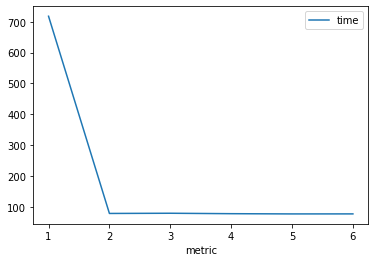

In [213]:
res=pd.DataFrame(res,columns=['metric','time'])
res.plot(x='metric')

In [17]:
cfg='/home/farrell/gitprojects/nanopore-project/test/custom.cfg'
run_guppy('test/fast5','test/basecall_fast'20,20,512,5)

guppy_basecaller -i test/fast5 -s test/basecall_fast --cpu_threads_per_caller 20 --num_callers 20 --chunks_per_runner 512         --gpu_runners_per_device 5         -c /home/farrell/gitprojects/nanopore-project/test/custom.cfg -x "cuda:0"


74.63200640678406

In [14]:
cfg='/home/farrell/gitprojects/nanopore-project/test/custom_hac.cfg'
run_guppy('test/fast5','test/basecall_hac',20,20,512,5)

guppy_basecaller -i test/fast5 -s test/basecall --cpu_threads_per_caller 20 --num_callers 20 --chunks_per_runner 512         --gpu_runners_per_device 5         -c /home/farrell/gitprojects/nanopore-project/test/custom_hac.cfg -x "cuda:0"


522.2056367397308

## bonito caller

## join fastqs

In [23]:
# join fastqs
def join_fastq(path, out):
    import gzip
    files = os.path.join(path,'*.fastq')
    cmd = 'cat {f} > {o}'.format(f=files,o=out)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    cmd = 'gzip %s' %out
    print ('compressing')
    subprocess.check_output(cmd,shell=True)
    return

join_fastq('test/basecall_hac/pass/', 'test/hac_joined.fastq')

cat test/basecall_hac/pass/*.fastq > hac_joined.fastq


## align with minimap2

In [34]:
out = 'test/hac.bam'
ref = 'phage_lambda.fasta'
#query = 'test/basecall_hac/pass/fastq_runid_15a87511c08725ce03507bdf86e85cdf36ec5a02_0_0.fastq'
query = 'test/hac_joined.fastq.gz'

def align_minimap2(query,out,ref,threads=4):
    cmd = 'minimap2 -ax map-ont -t {t} {r} {q} | samtools sort -o {o}'.format(o=out,r=ref,q=query,t=threads)
    print (cmd)
    subprocess.check_output(cmd,shell=True)
    
#align_minimap2(query,out,ref)

## m.bovis samples

In [ ]:
cfg='/home/farrell/gitprojects/nanopore-project/test/custom_hac.cfg'
path = '/storage/ONT/TB19-3825_05_OCT_21_GS/TB19-3825/20211005_1220_MN37978_FAQ44893_37c3a1fa/fast5/'
run_guppy(path,'test/TB19-3825',20,20,512,5)

In [51]:
name = 'TB20-3738'
#join_fastq('test/%s/pass'% name, 'test/%s.fastq' %name)
ref = 'Mbovis_AF212297.fa'
align_minimap2('test/%s.fastq.gz' %name,'test/%s-ont.bam' %name,ref,20)

minimap2 -ax map-ont -t 20 Mbovis_AF212297.fa test/TB20-3738.fastq.gz | samtools sort -o test/TB20-3738-ont.bam


## find depth/coverage of runs

In [211]:
for f in bam_files:
    c=tools.get_mean_depth(f)
    #depths.append(c)
    print (f,c)

test/mapped_mbovis/TB20-3762-ont.bam 154.73
test/mapped_mbovis/TB19-3825-ont.bam 130.61
test/mapped_mbovis/TB20-3738-ont.bam 624.09


## call variants with snipgenie and compare with illumina (duplicates)

In [ ]:
bam_files =app.get_files_from_paths('test/mapped_mbovis/', '*.bam')
gff_file='mbovis.gff'
tools.gff_bcftools_format(app.mbovis_gb, gff_file)

all_bam = ['/storage/btbgenie/dup_results/mapped/TB19-003738.bam',
          '/storage/btbgenie/dup_results/mapped/TB19-003825.bam',
          '/storage/btbgenie/dup_results/mapped/TB19-003762.bam',
          '/storage/btbgenie/monaghan/monaghan_results/mapped/3762.bam',
          '/storage/btbgenie/monaghan/monaghan_results/mapped/3738.bam',
          '/storage/btbgenie/monaghan/monaghan_results/mapped/3825.bam',
          ]

all_bam += bam_files
app.run_bamfiles(all_bam, app.mbovis_genome, outdir='test/variantcall', 
                 threads=20,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True)

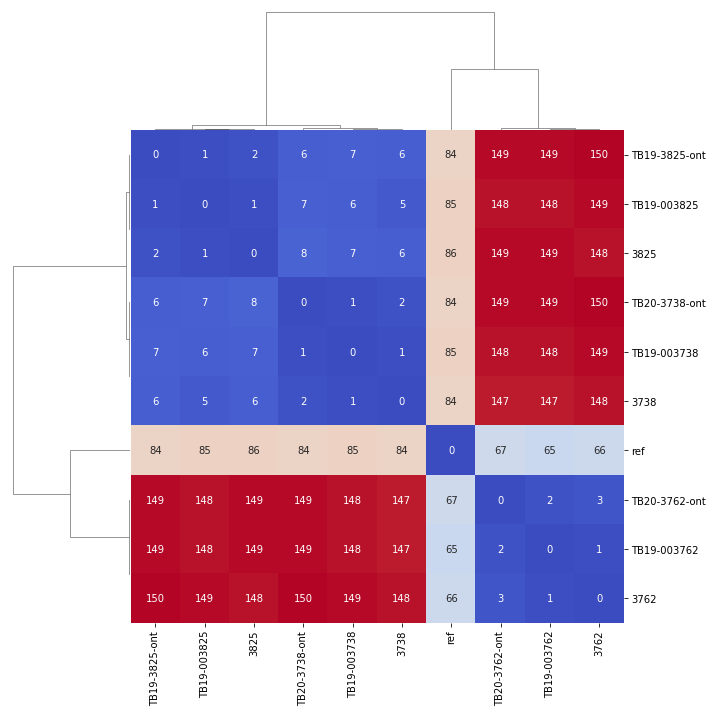

In [107]:
sdist = pd.read_csv('test/variantcall/snpdist.csv',index_col=0)
g=sns.clustermap(sdist,cmap='coolwarm',annot=True,fmt='.0f')
g.cax.set_visible(False)
g.savefig('snp_ont_compared_clustermap.png')

In [ ]:
import toytree
tre = toytree.tree('test/variantcall/tree.newick')
tre=tre.drop_tips(['ref'])
tre=tre.root('3762')
canvas,t,r=tre.draw(layout='r',width=1000,height=600,scalebar=True,)

In [219]:
csqmat = pd.read_csv('test/variantcall/csq.matrix')

In [250]:
dupsnps=[]
for i,g in df.groupby('pair'):
    c = list(g['sample'])   
    print (c)
    s = csqmat[c]
    s = s[c].sum(1)
    s = s[(s>0) &(s<3)]
    print (s)
    if len(s)==0:
        continue
    found = csqmat.loc[s.index]
    found['samples'] = 'v'.join(c)
    dupsnps.append(found)
    print (found[list(csqmat.columns[:4])+c])
    
dupsnps=pd.concat(dupsnps)
cols=list(csqmat.columns[:4])+['samples']
dupsnps[cols]

['TB19-003738', '3738', 'TB20-3738-ont']
17    2
dtype: int64
     start  gene       aa  snp_type  TB19-003738  3738  TB20-3738-ont
17  252261  pckA  95D>95G  missense            1     0              1
['TB19-003825', '3825', 'TB19-3825-ont']
Series([], dtype: int64)
['TB19-003762', '3762', 'TB20-3762-ont']
69     1
136    1
dtype: int64
       start            gene       aa    snp_type  TB19-003762  3762  \
69   1343752  BQ2027_MB1231c      43A  synonymous            0     0   
136  2840052          vapc18  12H>12R    missense            0     0   

     TB20-3762-ont  
69               1  
136              1  


,start,gene,aa,snp_type,samples
17,252261,pckA,95D>95G,missense,TB19-003738v3738vTB20-3738-ont
69,1343752,BQ2027_MB1231c,43A,synonymous,TB19-003762v3762vTB20-3762-ont
136,2840052,vapc18,12H>12R,missense,TB19-003762v3762vTB20-3762-ont


## assembly with Flye

In [116]:
query='test/TB19-3825.fastq.gz'
out='test/TB19-3825_flye'
threads=4
def flye_assembly(query, out, threads):
    cmd = 'flye --nano-raw {q} --out-dir {o} --threads {t}'.format(o=out,q=query,t=threads)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    return

In [140]:
query='test/TB20-3762.fastq.gz'
flye_assembly(query, 'test/TB20-3762_flye', 12)

flye --nano-raw test/TB20-3762.fastq.gz --out-dir test/TB20-3762_flye --threads 12


## annotation with pathogenie

In [ ]:
import pathogenie
res,recs = pathogenie.run_annotation('test/TB20-3762_flye/assembly.fasta', threads=10, trusted='Mbovis_AF212297_proteins.fa')
pathogenie.recs_to_genbank(recs, 'test/annot/TB20-3762.gbk')

In [206]:
def show_features(rec,start,end,i=1):
    from Bio import SeqIO    
    from dna_features_viewer import GraphicFeature, GraphicRecord
    from dna_features_viewer import BiopythonTranslator
    graphic_rec = BiopythonTranslator().translate_record(recs[i])
    cropped_rec = graphic_rec.crop((start,end))
    ax, _ = cropped_rec.plot(figure_width=14, strand_in_label_threshold=7)

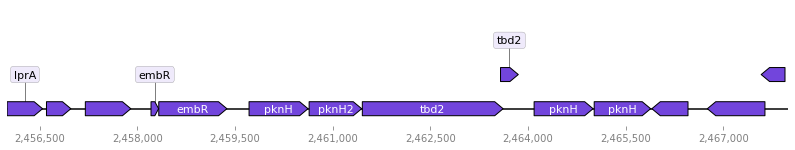

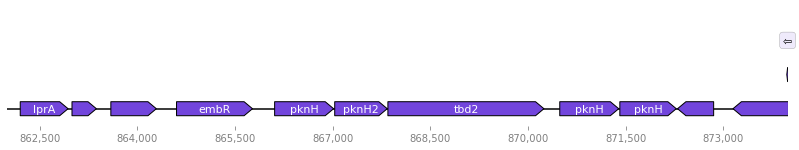

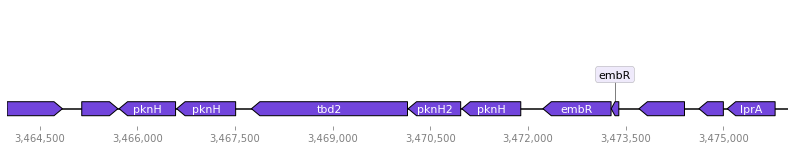

In [210]:
for name,st,i in zip(['TB20-3738','TB19-3825','TB20-3762'],[2456000,862000,3464000],[1,1,0]):
    recs = list(SeqIO.parse('test/annot/%s.gbk' %name,format='genbank'))
    show_features(recs[0],st,st+12000,i)